In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = None
# pd.set_option('display.max_colwidth', None)
from IPython.display import display, HTML
# display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [2]:
# !ls data/

In [3]:
# !ls sup_info/

## Functions

In [4]:
# created append_anomaly_counts function to get anomaly counts with different datasets & slices
def append_anomaly_counts(df_info=None, dataframe=None, col_suffix=""):
    res = []
    df_info["nunique"] = dataframe.nunique().values
    df_info["uknown_count"] = dataframe.eq("?").sum().values
    for idx, row in df_info.iterrows():
        column = row["column_name"]
        if row["column_type"] == "continuous":
            dataframe[column] = dataframe[column].astype(float)
            res.append({"column_name":column, "NIU_count":0})
        else:
            dataframe[column] = dataframe[column].astype(str)
            dataframe_NIU_mask = dataframe[column].str.contains("Not in universe")
            if dataframe_NIU_mask.any():
                dataframe_NIU_uval = dataframe[column][dataframe_NIU_mask].unique().item()
                NIU_count = dataframe[dataframe[column] == dataframe_NIU_uval].shape[0]
                res.append({"column_name":column, "NIU_count":NIU_count})
            else:
                res.append({"column_name":column, "NIU_count":0})
    # matching nominal column sanity check
    if (df_info[df_info["column_type"]=="nominal"]["column_name"].values == dataframe.select_dtypes(object).columns).all():
        df_info = pd.concat([df_info, pd.DataFrame(res)["NIU_count"]], axis=1)
        df_info = df_info.assign(row_count=dataframe.shape[0])
    return df_info

In [5]:
def change_target_value(dataframe=None):
    dataframe.loc[dataframe["target"] == "- 50000", "target"] = "0"
    dataframe.loc[dataframe["target"] == "50000+", "target"] = "1"
    return dataframe

In [6]:
def remap_cat_column(dataframe=None, column="", remap={}):
    return dataframe.replace({column:remap})

In [7]:
def categorical_target_eda(dataframe=None, column="", order=None, plot=True):
    ct = pd.crosstab(dataframe["target"], dataframe[column], normalize="index")
    if plot:
        # display(ct)
        g = sns.catplot(
            x=column,
            kind="count",
            col="target",
            order=order,
            data=dataframe,
            sharey=False,
        )
        g.set_xticklabels(rotation=60)
    return ct.T

In [8]:
def engineer_nominal(dataframe=None, columns=None, threshold=0.01):
    res = []
    for column in columns:
        remap = {}
        ct = categorical_target_eda(dataframe=dataframe, column=column, plot=False)
        s = ct["50000+"] - ct["- 50000"]
        for category, value in zip(s.index, s):
            if value > threshold:
                remap[category] = "gt"
            elif value < -threshold:
                remap[category] = "lt"
            else:
                remap[category] = "eq"
        res.append({column:remap})
    return res

In [9]:
def engineer_cat_columns(train_data=None, test_data=None, remaps=None, verbose=0):
    # select float columns for concatenation
    df_train_floats = train_data.select_dtypes(include=float)
    df_test_floats = test_data.select_dtypes(include=float)
    # initalize dataframes for concatenation
    df_train_remap = pd.DataFrame()
    df_test_remap = pd.DataFrame()
    # loop through list of dictionaries and remap values in categorical columns
    for remap in remaps:
        # get column from dictionary
        column = list(remap.keys())[0]
        # remap train
        df_train_temp = remap_cat_column(dataframe=train_data, column=column, remap=remap[column])
        df_train_remap = pd.concat([df_train_remap, df_train_temp[column]], axis=1)
        # remap test
        df_test_temp = remap_cat_column(dataframe=test_data, column=column, remap=remap[column])
        df_test_remap = pd.concat([df_test_remap, df_test_temp[column]], axis=1)
    
    df_train_remap = pd.concat([df_train_floats, df_train_remap, train_data["target"]], axis=1)
    df_test_remap = pd.concat([df_test_floats, df_test_remap, test_data["target"]], axis=1)

    if verbose > 0:
        display(df_train_remap.describe(include="float"))
        display(df_train_remap.describe(include="object"))
    
    return df_train_remap, df_test_remap

In [10]:
def fit_predict_train(X=None, y=None, model=None):
    model.fit(X, y)
    y_pred = model.predict(X)
    yhat = model.predict_proba(X)
    pos_probs = yhat[:, 1]

    precision, recall, thresholds = precision_recall_curve(y.astype(int), pos_probs)
    auc_score = auc(recall, precision)
    print(f"prauc: {auc_score}")
    print(classification_report(y, y_pred))
    
    return {"y":y, "pos_probs":pos_probs, "precision":precision, "recall":recall, "thresholds":thresholds}

In [11]:
def predict_test(X=None, y=None, model=None):
    y_pred = model.predict(X)
    yhat = model.predict_proba(X)
    pos_probs = yhat[:, 1]

    precision, recall, thresholds = precision_recall_curve(y.astype(int), pos_probs)
    auc_score = auc(recall, precision)
    print(f"prauc: {auc_score}")
    print(classification_report(y, y_pred))

    return {"y":y, "pos_probs":pos_probs, "precision":precision, "recall":recall, "thresholds":thresholds}

In [12]:
def display_prcurve(pr_res={}, name="unlabeled model", pos_label=None):
    f1_scores = 2 * pr_res["recall"] * pr_res["precision"] / (pr_res["recall"] + pr_res["precision"])
    
    best_th_ix = np.nanargmax(f1_scores)
    best_thresh = pr_res["thresholds"][best_th_ix]
    average_precision = average_precision_score(pr_res["y"], pr_res["pos_probs"], pos_label=pos_label)
    disp = PrecisionRecallDisplay(
        precision=pr_res["precision"],
        recall=pr_res["recall"],
        average_precision=average_precision,
        estimator_name=name,
        pos_label=pos_label
    )
    disp.plot(name=name)
    disp.ax_.set_title("Test Data")
    disp.ax_.plot(pr_res["recall"][best_th_ix], pr_res["precision"][best_th_ix], "ro", label=f"f1max (th = {best_thresh:.2f})")
    disp.ax_.legend()

## Get input data

In [13]:
df_train0 = pd.read_csv(
    filepath_or_buffer="data/census_income_learn.csv",
    header=None).drop(24,axis=1)

In [14]:
df_test0 = pd.read_csv(
    filepath_or_buffer="data/census_income_test.csv",
    header=None).drop(24,axis=1)

In [15]:
data_info = [
    "|   91 distinct values for attribute #0 (age) continuous",
    "|    9 distinct values for attribute #1 (class of worker) nominal",
    "|   52 distinct values for attribute #2 (detailed industry recode) nominal",
    "|   47 distinct values for attribute #3 (detailed occupation recode) nominal",
    "|   17 distinct values for attribute #4 (education) nominal",
    "| 1240 distinct values for attribute #5 (wage per hour) continuous",
    "|    3 distinct values for attribute #6 (enroll in edu inst last wk) nominal",
    "|    7 distinct values for attribute #7 (marital stat) nominal",
    "|   24 distinct values for attribute #8 (major industry code) nominal",
    "|   15 distinct values for attribute #9 (major occupation code) nominal",
    "|    5 distinct values for attribute #10 (race) nominal",
    "|   10 distinct values for attribute #11 (hispanic origin) nominal",
    "|    2 distinct values for attribute #12 (sex) nominal",
    "|    3 distinct values for attribute #13 (member of a labor union) nominal",
    "|    6 distinct values for attribute #14 (reason for unemployment) nominal",
    "|    8 distinct values for attribute #15 (full or part time employment stat) nominal",
    "|  132 distinct values for attribute #16 (capital gains) continuous",
    "|  113 distinct values for attribute #17 (capital losses) continuous",
    "| 1478 distinct values for attribute #18 (dividends from stocks) continuous",
    "|    6 distinct values for attribute #19 (tax filer stat) nominal",
    "|    6 distinct values for attribute #20 (region of previous residence) nominal",
    "|   51 distinct values for attribute #21 (state of previous residence) nominal",
    "|   38 distinct values for attribute #22 (detailed household and family stat) nominal",
    "|    8 distinct values for attribute #23 (detailed household summary in household) nominal",
    "|   10 distinct values for attribute #24 (migration code-change in msa) nominal",
    "|    9 distinct values for attribute #25 (migration code-change in reg) nominal",
    "|   10 distinct values for attribute #26 (migration code-move within reg) nominal",
    "|    3 distinct values for attribute #27 (live in this house 1 year ago) nominal",
    "|    4 distinct values for attribute #28 (migration prev res in sunbelt) nominal",
    "|    7 distinct values for attribute #29 (num persons worked for employer) continuous",
    "|    5 distinct values for attribute #30 (family members under 18) nominal",
    "|   43 distinct values for attribute #31 (country of birth father) nominal",
    "|   43 distinct values for attribute #32 (country of birth mother) nominal",
    "|   43 distinct values for attribute #33 (country of birth self) nominal",
    "|    5 distinct values for attribute #34 (citizenship) nominal",
    "|    3 distinct values for attribute #35 (own business or self employed) nominal",
    "|    3 distinct values for attribute #36 (fill inc questionnaire for veteran's admin) nominal",
    "|    3 distinct values for attribute #37 (veterans benefits) nominal",
    "|   53 distinct values for attribute #38 (weeks worked in year) continuous",
    "|    2 distinct values for attribute #39 (year) nominal",
]

## Clean data

In [16]:
s_data_info = pd.Series(data_info)\
    .str.replace("|", "")\
    .str.replace("distinct values for attribute #", ",")\
    .str.replace("(", ",")\
    .str.replace(")", ",")\
    .str.replace("'","")\
    .str.strip()
df_data_info = s_data_info.str.split(",", expand=True).drop(1,axis=1)
df_data_info.columns = ["nunique", "column_name", "column_type"]
df_data_info["nunique"] = df_data_info["nunique"].astype(int)
df_data_info.loc[40] = [2, "target", "nominal"]
df_data_info = df_data_info.map(lambda x: x.strip() if isinstance(x, str) else x)

#### train data clean
- df_train1

In [17]:
print(f"inital shape: {df_train0.shape}")
print(f"number of dups: {df_train0.duplicated().sum()}") # different total than metadata file (46627 vs.46716)
if (df_train0.nunique().reset_index(drop=True) == df_data_info["nunique"]).all():
    print("renaming columns\n")
    df_train0.columns = df_data_info["column_name"].tolist()
df_train0 = df_train0.map(lambda x: x.strip() if isinstance(x, str) else x)
df_train0["target"] = df_train0["target"].str.replace(".", "")

# drop duplicate rows
df_train1 = df_train0.drop_duplicates(ignore_index=True)
print(f"shape after drop dups: {df_train1.shape}")

# if edu is Children then target < 50k
print("\nfilter Children - target counts")
print(df_train1[df_train1["education"]=="Children"]["target"].value_counts())

df_train1 = df_train1[df_train1["education"]!="Children"].reset_index(drop=True)
print(f"\nshape after drop Children: {df_train1.shape}")
# print(df_train1.duplicated().sum())

df_info_train = append_anomaly_counts(df_info=df_data_info, dataframe=df_train1)

print("\ntarget distribution")
print(df_train1["target"].value_counts())

inital shape: (199523, 41)
number of dups: 46627
renaming columns

shape after drop dups: (152896, 41)

filter Children - target counts
target
- 50000    12710
Name: count, dtype: int64

shape after drop Children: (140186, 41)

target distribution
target
- 50000    127819
50000+      12367
Name: count, dtype: int64


#### Test data clean
- df_test1

In [18]:
print(f"inital shape: {df_test0.shape}")
print(f"number of dups: {df_test0.duplicated().sum()}")
print("renaming columns\n")
df_test0.columns = df_data_info["column_name"].tolist()
df_test0 = df_test0.map(lambda x: x.strip() if isinstance(x, str) else x)
df_test0["target"] = df_test0["target"].str.replace(".", "")

# drop duplicate rows
df_test1 = df_test0.drop_duplicates(ignore_index=True)
print(f"shape after drop dups: {df_test1.shape}")

# if edu is Children then target < 50k
print("\nfilter Children - target counts")
print(df_test1[df_test1["education"]=="Children"]["target"].value_counts())

df_test1 = df_test1[df_test1["education"]!="Children"].reset_index(drop=True)
print(f"\nshape after drop Children: {df_test1.shape}")
# print(df_test1.duplicated().sum())

df_info_test = append_anomaly_counts(df_info=df_data_info, dataframe=df_test1)

print("\ntarget distribution")
print(df_test1["target"].value_counts())

inital shape: (99762, 41)
number of dups: 20898
renaming columns

shape after drop dups: (78864, 41)

filter Children - target counts
target
- 50000    7264
Name: count, dtype: int64

shape after drop Children: (71600, 41)

target distribution
target
- 50000    65414
50000+      6186
Name: count, dtype: int64


## Feature engineering

In [19]:
# filter nominal columns and exclude target
df_nominal = df_info_train[(df_info_train["column_type"] == "nominal") & (df_info_train["column_name"] != "target")]

# filtered column lists - nominal columns (nc)
nc_all = df_nominal["column_name"].values
nc_noUnknown = df_nominal[df_nominal["uknown_count"] == 0]["column_name"].values
nc_noNIU = df_nominal[df_nominal["NIU_count"] == 0]["column_name"].values
nc_noUnknownORnoNIU = df_nominal[(df_nominal["uknown_count"] == 0) & (df_nominal["NIU_count"] == 0)]["column_name"].values

res_nc_all = engineer_nominal(dataframe=df_train1, columns=nc_all, threshold=0.01)
print(f"nc_all--dataframe shape: {nc_all.shape[0]} | result column size: {len(res_nc_all)}")
res_nc_noUnknown = engineer_nominal(dataframe=df_train1, columns=nc_noUnknown, threshold=0.01)
print(f"nc_noUnknown--dataframe shape: {nc_noUnknown.shape[0]} | result column size: {len(res_nc_noUnknown)}")
res_nc_noNIU = engineer_nominal(dataframe=df_train1, columns=nc_noNIU, threshold=0.01)
print(f"nc_noNIU--dataframe shape: {nc_noNIU.shape[0]} | result column size: {len(res_nc_noNIU)}")
res_nc_noUnknownORnoNIU = engineer_nominal(dataframe=df_train1, columns=nc_noUnknownORnoNIU, threshold=0.01)
print(f"nc_noUnknownORnoNIU--dataframe shape: {nc_noUnknownORnoNIU.shape[0]} | result column size: {len(res_nc_noUnknownORnoNIU)}")

nc_all--dataframe shape: 33 | result column size: 33
nc_noUnknown--dataframe shape: 25 | result column size: 25
nc_noNIU--dataframe shape: 21 | result column size: 21
nc_noUnknownORnoNIU--dataframe shape: 15 | result column size: 15


#### remap categories

In [20]:
df_train_remap, df_test_remap = engineer_cat_columns(
    train_data=df_train1,
    test_data=df_test1,
    remaps=res_nc_all,
    verbose=0,
)

## Prepare model data

In [21]:
df_train2 = change_target_value(dataframe=df_train_remap)
df_test2 = change_target_value(dataframe=df_test_remap)

In [22]:
df_train2["target"].value_counts()

target
0    127819
1     12367
Name: count, dtype: int64

In [23]:
df_test2["target"].value_counts()

target
0    65414
1     6186
Name: count, dtype: int64

In [24]:
# # BALANCE DATA - NOT USED YET...
# df_class0 = df_train2[df_train2["target"] == "0"]
# df_class1 = df_train2[df_train2["target"] == "1"]

# df_class0_sample = df_class0.sample(n=df_class1.shape[0], random_state=42, axis=0)
# df_train2 = pd.concat([df_class0_sample, df_class1], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

In [25]:
X_train0 = df_train2.drop("target", axis=1)
y_train0 = df_train2["target"]

In [26]:
X_test0 = df_test2.drop("target", axis=1)
y_test0 = df_test2["target"]

In [27]:
# drop bad features somehow passing MIC
drop_cols = [
    "reason for unemployment",
    "family members under 18",
    "fill inc questionnaire for veterans admin",
]
print(drop_cols)

X_train0.drop(drop_cols, axis=1, inplace=True)
X_test0.drop(drop_cols, axis=1, inplace=True)

['reason for unemployment', 'family members under 18', 'fill inc questionnaire for veterans admin']


In [28]:
matching_cols = X_train0.select_dtypes(object).nunique() == X_test0.select_dtypes(object).nunique()
cat_features = matching_cols[matching_cols==True].index.tolist()

In [29]:
num_features = [
    "age",
    "dividends from stocks",
    "num persons worked for employer", ###
    "weeks worked in year", ###
]
features = num_features + cat_features
X_train1 = pd.get_dummies(X_train0.loc[:, features])
X_test1 = pd.get_dummies(X_test0.loc[:, features])
print(X_train1.shape)
print(X_test1.shape)

(140186, 86)
(71600, 86)


In [30]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train1.loc[:, num_features] = scalar.fit_transform(X_train1.loc[:, num_features])
X_test1.loc[:, num_features] = scalar.fit_transform(X_test1.loc[:, num_features])

In [31]:
from sklearn.feature_selection import mutual_info_classif as MIC
mi_score = MIC(X_train1, y_train0, random_state=42)

In [32]:
col_MIC_mask = mi_score > np.percentile(a=mi_score, q=75)
selected_features = ["num persons worked for employer"] + X_train1.columns[col_MIC_mask].tolist()

X_train2 = X_train1.loc[:, selected_features]
X_test2 = X_test1.loc[:, selected_features]
print(X_train2.shape)
print(X_test2.shape)

(140186, 23)
(71600, 23)


## Models

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced.
- high precision relates to a low `false positive rate`
- high recall relates to a low `false negative rate`

In [33]:
len(selected_features)

23

### logistic regression - baseline model

In [34]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [35]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=10000,
    class_weight="balanced",
    random_state=42
)

In [36]:
print("TRAIN RESULTS")
train_res = fit_predict_train(X=X_train2, y=y_train0, model=model)

TRAIN RESULTS
prauc: 0.4899348731476387
              precision    recall  f1-score   support

           0       0.98      0.79      0.88    127819
           1       0.28      0.83      0.42     12367

    accuracy                           0.80    140186
   macro avg       0.63      0.81      0.65    140186
weighted avg       0.92      0.80      0.84    140186



TEST RESULTS
prauc: 0.49052024976506
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     65414
           1       0.28      0.83      0.42      6186

    accuracy                           0.80     71600
   macro avg       0.63      0.81      0.65     71600
weighted avg       0.92      0.80      0.84     71600



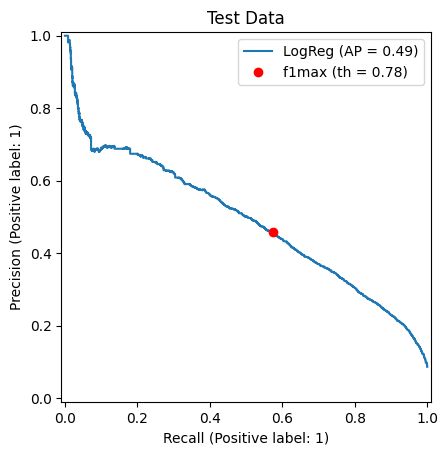

In [37]:
print("TEST RESULTS")
test_res_baseline = predict_test(X=X_test2, y=y_test0, model=model)
display_prcurve(pr_res=test_res_baseline, name="LogReg", pos_label="1")

In [38]:
# disp = ConfusionMatrixDisplay(
#     confusion_matrix=confusion_matrix(y_train0, y_pred, labels=model.classes_),
#     display_labels=model.classes_
# )
# disp.plot(cmap="Blues", values_format="", colorbar=False)

### Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=2,
    max_features=0.3,
    random_state=42,
    class_weight="balanced",
    criterion="gini"
)

In [40]:
print("TRAIN RESULTS")
train_res = fit_predict_train(X=X_train2, y=y_train0, model=model)

TRAIN RESULTS
prauc: 0.5519507753540509
              precision    recall  f1-score   support

           0       0.98      0.84      0.90    127819
           1       0.33      0.84      0.48     12367

    accuracy                           0.84    140186
   macro avg       0.66      0.84      0.69    140186
weighted avg       0.92      0.84      0.87    140186



TEST RESULTS
prauc: 0.5288464124470673
              precision    recall  f1-score   support

           0       0.98      0.84      0.90     65414
           1       0.32      0.80      0.46      6186

    accuracy                           0.84     71600
   macro avg       0.65      0.82      0.68     71600
weighted avg       0.92      0.84      0.86     71600



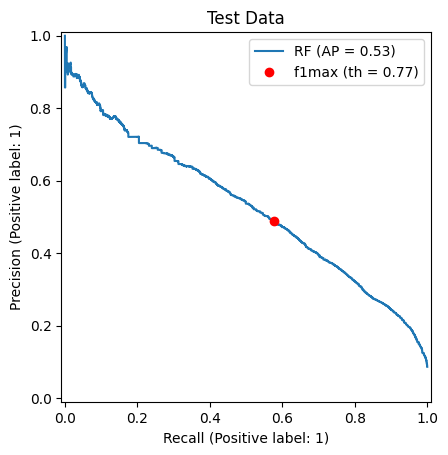

In [41]:
print("TEST RESULTS")
test_res_RF = predict_test(X=X_test2, y=y_test0, model=model)
display_prcurve(pr_res=test_res_RF, name="RF", pos_label="1")

### MLP

In [42]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(
    random_state=42,
    max_iter=300
)

In [43]:
print("TRAIN RESULTS")
train_res = fit_predict_train(X=X_train2, y=y_train0, model=model)

TRAIN RESULTS
prauc: 0.5552647522469556
              precision    recall  f1-score   support

           0       0.94      0.98      0.96    127819
           1       0.64      0.38      0.48     12367

    accuracy                           0.93    140186
   macro avg       0.79      0.68      0.72    140186
weighted avg       0.92      0.93      0.92    140186



TEST RESULTS
prauc: 0.5447071116592067
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     65414
           1       0.64      0.39      0.48      6186

    accuracy                           0.93     71600
   macro avg       0.79      0.68      0.72     71600
weighted avg       0.92      0.93      0.92     71600



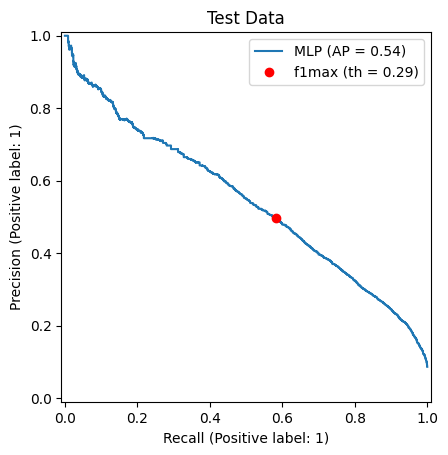

In [44]:
print("TEST RESULTS")
test_res_MLP = predict_test(X=X_test2, y=y_test0, model=model)
display_prcurve(pr_res=test_res_MLP, name="MLP", pos_label="1")

### KNN (overfit)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train1, y_train0)

In [ ]:
y_pred = model.predict(X_train1)
yhat = model.predict_proba(X_train1)
pos_probs = yhat[:, 1]
precision, recall, _ = precision_recall_curve(y_train0.astype(int).values, pos_probs)
auc_score = auc(recall, precision)
print(f"prauc: {auc_score}")
# print(confusion_matrix(y_train0, y_pred))
print(classification_report(y_train0, y_pred))

In [ ]:
y_pred = model.predict(X_test1)
yhat = model.predict_proba(X_test1)
pos_probs = yhat[:, 1]
precision, recall, _ = precision_recall_curve(y_test0.astype(int).values, pos_probs)
auc_score = auc(recall, precision)
print(f"prauc: {auc_score}")
# print(confusion_matrix(y_test0, y_pred))
print(classification_report(y_test0, y_pred))

## Ensemble

In [ ]:
test_res_RF["pos_probs"]

In [ ]:
test_res_MLP["pos_probs"]

In [ ]:
display = PrecisionRecallDisplay.from_predictions(
    test_res_RF["y"].astype(int), pd.Series((test_res_RF["pos_probs"] + test_res_MLP["pos_probs"]) / 2, name="proba1_avg"), name="ensemble", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

## Single category column EDA

In [45]:
selected_features_series = pd.Series(selected_features)
cols = selected_features_series[selected_features_series.str.contains("_")].str.split("_").str[0].unique()
pd.Series(cols)

0                             class of worker
1                    detailed industry recode
2                  detailed occupation recode
3                                   education
4                                marital stat
5                         major industry code
6                       major occupation code
7                             hispanic origin
8                                         sex
9           full or part time employment stat
10                             tax filer stat
11         detailed household and family stat
12    detailed household summary in household
dtype: object

parent column: education

TRAIN DATA: 140186


education,lt,eq,gt
target,,,
- 50000,0.758385,0.074707,0.166908
50000+,0.321258,0.066629,0.612113



TEST DATA: 71600


education,lt,eq,gt
target,,,
- 50000,0.763766,0.072553,0.163681
50000+,0.324927,0.061914,0.613159


7    education_gt
8    education_lt
dtype: object


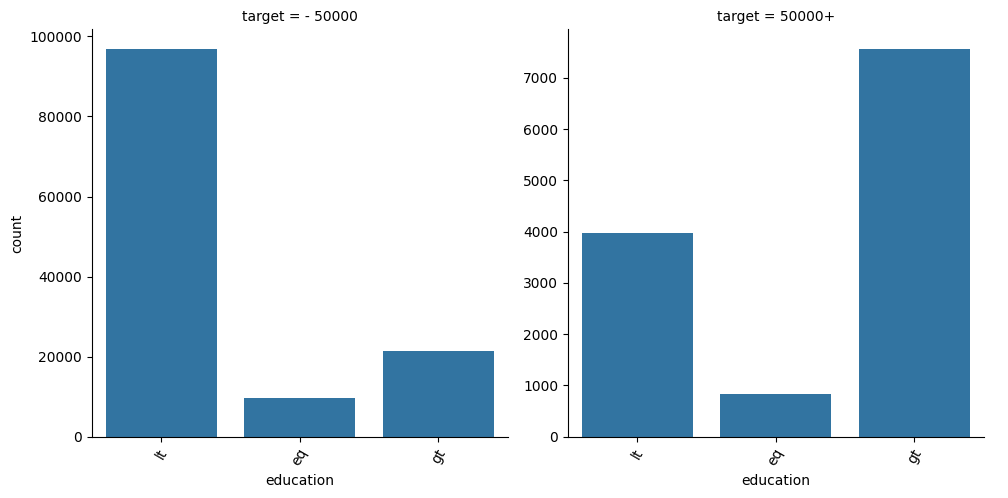

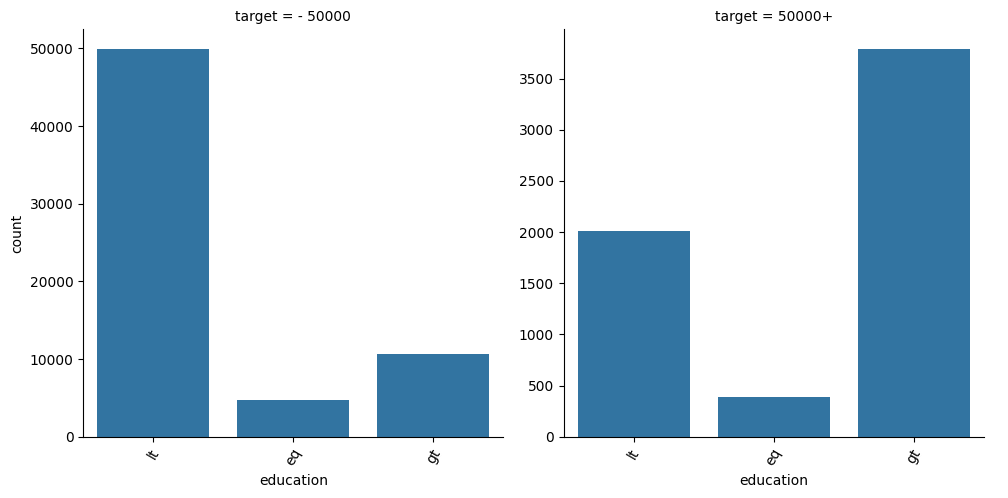

In [46]:
n=3
for col in cols[n:n+1]:
    print(f"parent column: {col}\n")
    ct = categorical_target_eda(dataframe=df_train1, column=col, plot=False)
    s = ct["50000+"] - ct["- 50000"]
    
    remap = {}
    threshold = 0.01
    for category, value in zip(s.index, s):
        if value > threshold:
            remap[category] = "gt"
        elif value < -threshold:
            remap[category] = "lt"
        else:
            remap[category] = "eq"
    
    df_train_remap = remap_cat_column(dataframe=df_train1, column=col, remap=remap)
    ct = categorical_target_eda(dataframe=df_train_remap, column=col, order=["lt", "eq", "gt"], plot=True)
    print(f"TRAIN DATA: {df_train1.shape[0]}")
    display(ct.T.loc[:, ["lt", "eq", "gt"]])
    
    df_test_remap = remap_cat_column(dataframe=df_test1, column=col, remap=remap)
    ct = categorical_target_eda(dataframe=df_test_remap, column=col, order=["lt", "eq", "gt"], plot=True)
    print(f"\nTEST DATA: {df_test1.shape[0]}")
    display(ct.T.loc[:, ["lt", "eq", "gt"]])

    print(selected_features_series[selected_features_series.str.contains(col)])

- reason for unemployment
- family members under 18
- fill inc questionnaire for veterans admin

## EDA

### descriptive statistics

In [ ]:
df_train1.describe()

In [ ]:
df_train1.describe(include="object")

### plot categorical distributions

In [ ]:
cat_cols = df_train1.select_dtypes(include='object')

In [ ]:
for col in cat_cols:
    n = df_train1[col].nunique()
    if n <= 22:
        sns.countplot(
            y=col,
            data=df_train1,
            hue=col,
            palette=sns.color_palette(palette="colorblind", n_colors=n),
            legend=False
        )
        plt.show()

### slice target by categorical features

In [ ]:
display(pd.crosstab(df_train1['target'], df_train1["education"], normalize='index'))

In [ ]:
g = sns.catplot(x = "education", kind='count', col = 'target', data=df_train1, sharey=False)
g.set_xticklabels(rotation=90)

In [ ]:
for col in cat_cols:
    if df_train1[col].nunique() <=4:
        display(pd.crosstab(df_train1['target'], df_train1[col], normalize='index'))

In [ ]:
for col in cat_cols:
    if df_train1[col].nunique() <= 4:
        g = sns.catplot(x = col, kind='count', col = 'target', data=df_train1, sharey=False)
        g.set_xticklabels(rotation=60)

### slice target by numerical features

In [ ]:
num_cols = df_train1.select_dtypes(float).columns.values

In [ ]:
for col in num_cols:
    df_train1[col].hist(bins=20)
    print(col)
    plt.show()

In [ ]:
for col in num_cols:
    sns.boxplot(
        y=df_train1['target'].astype('category'),
        hue=df_train1['target'].astype('category'),
        x=col,
        data=df_train1,
        palette=sns.color_palette(palette="colorblind", n_colors=2)
    )
    plt.show()

### Group numerical features (mean) by categorical features

In [ ]:
for col in cat_cols:
    if df_train1[col].nunique() <= 3:
        display(df_train1.groupby(col)[num_cols].mean())

### Correlation matrix for numerical features

In [ ]:
corr = df_train1.select_dtypes(float).corr()
corr

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(corr, cmap='RdBu_r', annot=True, vmax=1, vmin=-1)
plt.show()